# Project Background and Objectives:
- In recent years, with the development of Generative AI, more and more images are being generated automatically by AI on the Internet. Although image generation is a useful technology, the inability to distinguish between real and generated images is thought to create various problems.
- Therefore, the objective of this project is to construct a model that can distinguish between AI-generated images and real images using CNN.

# Dataset
- We use CIFAKE(https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images).

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob 
import cv2
from skimage.io import imread 
import os
import shutil
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

In [7]:
print(len(os.listdir('./train/REAL')))
print(len(os.listdir('./train/FAKE')))
print(len(os.listdir('./test/REAL')))
print(len(os.listdir('./test/FAKE')))

50000
50000
10000
10000


# Data Preparation

In [9]:
# split data into train and validation sets
train_dir = './train'

# create a new directory
base_dir = './data'
os.mkdir(base_dir)

# create train and validation directories
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# create train and validation directories for real and fake images
train_real_dir = os.path.join(train_dir, 'REAL')
os.mkdir(train_real_dir)
train_fake_dir = os.path.join(train_dir, 'FAKE')
os.mkdir(train_fake_dir)
validation_real_dir = os.path.join(validation_dir, 'REAL')
os.mkdir(validation_real_dir)
validation_fake_dir = os.path.join(validation_dir, 'FAKE')
os.mkdir(validation_fake_dir)

val_size = 0.2
filename_real = os.listdir('./train/REAL')
filename_fake = os.listdir('./train/FAKE')

# split real images into train and validation sets
train_real, validation_real = train_test_split(filename_real, test_size=val_size, random_state=1)

# split fake images into train and validation sets
train_fake, validation_fake = train_test_split(filename_fake, test_size=val_size, random_state=1)

# copy and paste the images into the respective train and validation directories
for filename in train_real:
    shutil.copy(os.path.join('./train/REAL', filename), os.path.join(train_real_dir, filename))
for filename in train_fake:
    shutil.copy(os.path.join('./train/FAKE', filename), os.path.join(train_fake_dir, filename))
for filename in validation_real:
    shutil.copy(os.path.join('./train/REAL', filename), os.path.join(validation_real_dir, filename))
for filename in validation_fake:
    shutil.copy(os.path.join('./train/FAKE', filename), os.path.join(validation_fake_dir, filename))

# check the number of images in each directory
print(len(os.listdir('./data/train/REAL')))
print(len(os.listdir('./data/train/FAKE')))
print(len(os.listdir('./data/validation/REAL')))
print(len(os.listdir('./data/validation/FAKE')))


40000
40000
10000
10000


# Data Augumentation

In [10]:
data_augmentation = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rotation_range=180,
                                       zoom_range=0.4, 
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       channel_shift_range=0.3)

In [11]:
batch_size = 192
image_size = 96

train_path = './data/train'
val_path = './data/validation'
test_path = './test'

train_set = data_augmentation.flow_from_directory(train_path,
                                                            target_size = (image_size,image_size),
                                                            batch_size = batch_size,
                                                            class_mode = 'binary')
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size = (image_size,image_size),
                                                                        batch_size = batch_size,
                                                                        class_mode = 'binary')
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                           target_size = (image_size,image_size),
                                                                           batch_size = batch_size,
                                                                           class_mode = 'binary',
                                                                           shuffle = False)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Model Building

In [13]:
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)

xception = Xception(include_top = False, input_shape= input_shape)(inputs)
mobile_net = MobileNetV2(include_top = False, input_shape= input_shape)(inputs)

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(mobile_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

2023-12-10 15:16:10.630072: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-10 15:16:10.630112: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-12-10 15:16:10.630123: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-12-10 15:16:10.630169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 15:16:10.630189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 xception (Functional)       (None, 3, 3, 2048)           2086148   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)           2257984   ['input_1[0][0]']             
 ional)                                                                                           
                                                                                              

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training

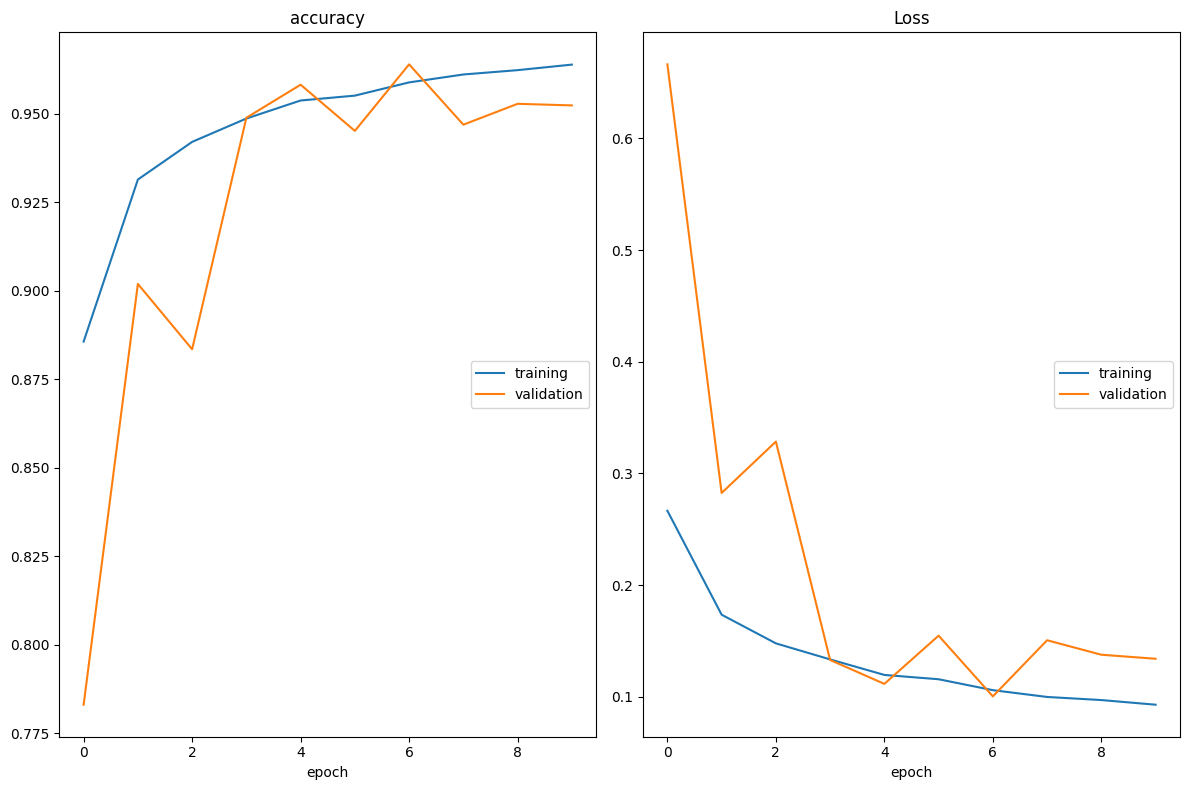

accuracy
	training         	 (min:    0.886, max:    0.964, cur:    0.964)
	validation       	 (min:    0.783, max:    0.964, cur:    0.952)
Loss
	training         	 (min:    0.093, max:    0.267, cur:    0.093)
	validation       	 (min:    0.100, max:    0.666, cur:    0.134)
417/417 [==============================] - 297s 712ms/step - loss: 0.0929 - accuracy: 0.9639 - val_loss: 0.1341 - val_accuracy: 0.9524


In [14]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_set,
                                steps_per_epoch=len(train_set), 
                                validation_data=val_set,
                                validation_steps=len(val_set),
                                epochs=10,
                                verbose=1,
                                callbacks=PlotLossesKeras())

In [15]:
model.save('model.h5')

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict and Evaluation

In [16]:
loss, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

/var/folders/_1/_y6lxkm177x0g8qp8xrnnxrh0000gn/T/ipykernel_26510/1961411515.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=1)


105/105 [==============================] - 18s 171ms/step - loss: 0.1342 - accuracy: 0.9541
Test loss: 0.13422943651676178
Test accuracy: 0.9541000127792358


# Conclusion

As a result, the model we have built can distinguish test data from real or AI-generated images with 95% accuracy.

Since the data used in this study is very limited in terms of image type and size, it cannot be used as-is for AI image detection.